In [46]:

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pytorch_experiment
plt.rcParams['image.cmap'] = 'gray'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()


import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="cifar10"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=pytorch_experiment.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


x_train shape: (50000, 32, 32, 3) uint8
x_test shape: (10000, 32, 32, 3) uint8
y_train shape: (50000, 10) float64
y_test shape: (10000, 10) float64
50000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [49]:
conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128}

def subset(l,indices):
    return [l[i] for i in indices]

def freeze_layers_except(layers,layer_names,layers_to_train):
    for i in range(len(layers)):
        name=layer_names[i]
        layer=layers[i]
        requires_grad=name in layers_to_train
        #print(f"Layer {name}: setting requires_grad to {requires_grad}.")
        for param in layer.parameters():
            param.requires_grad=requires_grad


            
def model_optimizer_generator(previous_model=None,trainable_layers=None):
    model = pytorch_models.SimpleConv(dataset.input_shape,dataset.num_classes,
                                     conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
    if use_cuda:
        model=model.cuda()
    if previous_model:
        model.load_state_dict(previous_model.state_dict())
        
    if trainable_layers:
        freeze_layers_except(model.layers(),model.layer_names(),trainable_layers)
        
    parameters=pytorch_experiment.add_weight_decay(model.named_parameters(),1e-9)
    optimizer = optim.Adam(parameters, lr=0.001)
    
    return model,optimizer

model,optimizer=model_optimizer_generator()
print(model)



SimpleConv(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [50]:

batch_size = 64

epochs={'cifar10':10,'mnist':5,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}

rotated_epochs={'cifar10':80,'mnist':5,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

layer_names=model.layer_names()
loss_function=torch.nn.NLLLoss()
batch_size=64
initial_epochs=4
retrain_epochs=7
conv_layer_names= list(filter(lambda name: name.startswith("c"),layer_names))
fc_layer_names= list(filter(lambda name: name.startswith("fc"),layer_names))
individual_layers= [[l] for l in layer_names] 
retrained_layers_schemes=individual_layers + [conv_layer_names,fc_layer_names] +[layer_names]

labels=["none"] +layer_names +["conv","fc","all"]

# retrained_layers_schemes=[conv_layer_names,fc_layer_names]
# labels=["conv","fc"]
print("Retraining schemes:\n")
print("\n".join(map(lambda scheme: "_".join(scheme),retrained_layers_schemes)))

config=pytorch_experiment.RetrainConfig(batch_size,initial_epochs,retrain_epochs,use_cuda,loss_function)
scores,models,unrotated_accuracies,rotated_accuracies=pytorch_experiment.retraining(model_optimizer_generator,retrained_layers_schemes,config,dataset)





Retraining schemes:

c1
c2
c3
c4
c5
fc1
fc2
c1_c2_c3_c4_c5
fc1_fc2
c1_c2_c3_c4_c5_fc1_fc2


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Training vanilla network with unrotated dataset..


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.34, accuracy:  0.511, Time:  0:00:22


Test => Loss: 0.9901, Accuracy: 65.06% (6506/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:  0.824, accuracy:  0.711, Time:  0:00:22


Test => Loss: 0.7809, Accuracy: 72.87% (7287/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:  0.616, accuracy:  0.785, Time:  0:00:24


Test => Loss: 0.6870, Accuracy: 76.49% (7649/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:  0.471, accuracy:  0.836, Time:  0:00:22


Test => Loss: 0.6894, Accuracy: 77.38% (7738/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c1'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.94, accuracy:  0.321, Time:  0:00:16


Test => Loss: 1.8538, Accuracy: 33.14% (3314/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.82, accuracy:  0.342, Time:  0:00:17


Test => Loss: 1.8127, Accuracy: 35.20% (3520/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.79, accuracy:  0.358, Time:  0:00:18


Test => Loss: 1.7805, Accuracy: 36.31% (3631/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.77, accuracy:  0.368, Time:  0:00:21


Test => Loss: 1.7506, Accuracy: 36.92% (3692/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.75, accuracy:  0.368, Time:  0:00:22


Test => Loss: 1.7733, Accuracy: 36.89% (3689/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.74, accuracy:  0.374, Time:  0:00:22


Test => Loss: 1.7628, Accuracy: 37.20% (3720/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.73, accuracy:  0.378, Time:  0:00:22


Test => Loss: 1.7282, Accuracy: 37.73% (3773/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c2'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.74, accuracy:  0.379, Time:  0:00:24


Test => Loss: 1.6741, Accuracy: 39.06% (3906/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.64, accuracy:  0.408, Time:  0:00:23


Test => Loss: 1.6378, Accuracy: 41.42% (4142/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:    1.6, accuracy:  0.421, Time:  0:00:23


Test => Loss: 1.6103, Accuracy: 41.58% (4158/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.59, accuracy:  0.429, Time:  0:00:24


Test => Loss: 1.6080, Accuracy: 42.84% (4284/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.57, accuracy:  0.434, Time:  0:00:23


Test => Loss: 1.5668, Accuracy: 43.42% (4342/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.56, accuracy:  0.437, Time:  0:00:23


Test => Loss: 1.5877, Accuracy: 42.89% (4289/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.54, accuracy:  0.444, Time:  0:00:21


Test => Loss: 1.5604, Accuracy: 42.82% (4282/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c3'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.68, accuracy:  0.401, Time:  0:00:22


Test => Loss: 1.5941, Accuracy: 43.56% (4356/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.54, accuracy:  0.444, Time:  0:00:20


Test => Loss: 1.5373, Accuracy: 43.76% (4376/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:    1.5, accuracy:  0.459, Time:  0:00:21


Test => Loss: 1.5054, Accuracy: 45.93% (4593/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.48, accuracy:  0.468, Time:  0:00:21


Test => Loss: 1.4925, Accuracy: 46.47% (4647/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.46, accuracy:  0.475, Time:  0:00:21


Test => Loss: 1.4728, Accuracy: 46.75% (4675/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.45, accuracy:  0.477, Time:  0:00:22


Test => Loss: 1.4484, Accuracy: 47.43% (4743/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.44, accuracy:  0.483, Time:  0:00:22


Test => Loss: 1.4455, Accuracy: 47.60% (4760/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c4'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.63, accuracy:  0.418, Time:  0:00:20


Test => Loss: 1.5346, Accuracy: 44.54% (4454/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.48, accuracy:  0.466, Time:  0:00:20


Test => Loss: 1.4625, Accuracy: 47.27% (4727/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.43, accuracy:  0.484, Time:  0:00:21


Test => Loss: 1.4184, Accuracy: 48.71% (4871/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:    1.4, accuracy:  0.499, Time:  0:00:19


Test => Loss: 1.3917, Accuracy: 49.21% (4921/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.38, accuracy:    0.5, Time:  0:00:20


Test => Loss: 1.3907, Accuracy: 49.53% (4953/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.36, accuracy:  0.506, Time:  0:00:21


Test => Loss: 1.3661, Accuracy: 50.51% (5051/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.35, accuracy:  0.512, Time:  0:00:21


Test => Loss: 1.3657, Accuracy: 51.00% (5100/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c5'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.57, accuracy:  0.436, Time:  0:00:21


Test => Loss: 1.4818, Accuracy: 47.33% (4733/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.41, accuracy:  0.492, Time:  0:00:21


Test => Loss: 1.3904, Accuracy: 50.88% (5088/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.36, accuracy:  0.513, Time:  0:00:20


Test => Loss: 1.3523, Accuracy: 51.49% (5149/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.33, accuracy:  0.525, Time:  0:00:21


Test => Loss: 1.3182, Accuracy: 52.49% (5249/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:    1.3, accuracy:  0.535, Time:  0:00:21


Test => Loss: 1.3009, Accuracy: 52.78% (5278/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.29, accuracy:  0.541, Time:  0:00:20


Test => Loss: 1.3029, Accuracy: 53.43% (5343/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.26, accuracy:  0.551, Time:  0:00:19


Test => Loss: 1.2894, Accuracy: 53.80% (5380/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['fc1'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.55, accuracy:  0.448, Time:  0:00:20


Test => Loss: 1.4326, Accuracy: 48.80% (4880/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.38, accuracy:  0.509, Time:  0:00:19


Test => Loss: 1.3636, Accuracy: 52.04% (5204/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.32, accuracy:  0.532, Time:  0:00:20


Test => Loss: 1.3267, Accuracy: 53.07% (5307/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.29, accuracy:  0.545, Time:  0:00:20


Test => Loss: 1.3170, Accuracy: 53.24% (5324/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.27, accuracy:   0.55, Time:  0:00:20


Test => Loss: 1.3068, Accuracy: 54.60% (5460/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.25, accuracy:  0.561, Time:  0:00:16


Test => Loss: 1.2811, Accuracy: 55.75% (5575/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.24, accuracy:  0.564, Time:  0:00:15


Test => Loss: 1.2798, Accuracy: 55.27% (5527/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['fc2'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.83, accuracy:  0.368, Time:  0:00:18


Test => Loss: 1.7251, Accuracy: 37.53% (3753/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:    1.7, accuracy:  0.383, Time:  0:00:18


Test => Loss: 1.6958, Accuracy: 38.50% (3850/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.69, accuracy:  0.389, Time:  0:00:15


Test => Loss: 1.7033, Accuracy: 38.34% (3834/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:    1.7, accuracy:  0.386, Time:  0:00:16


Test => Loss: 1.7048, Accuracy: 38.58% (3858/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:    1.7, accuracy:  0.384, Time:  0:00:19


Test => Loss: 1.6983, Accuracy: 38.30% (3830/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:    1.7, accuracy:   0.39, Time:  0:00:20


Test => Loss: 1.6950, Accuracy: 38.34% (3834/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:    1.7, accuracy:  0.387, Time:  0:00:20


Test => Loss: 1.6967, Accuracy: 38.83% (3883/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c1', 'c2', 'c3', 'c4', 'c5'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.48, accuracy:  0.465, Time:  0:00:28


Test => Loss: 1.3445, Accuracy: 51.54% (5154/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.29, accuracy:  0.536, Time:  0:00:29


Test => Loss: 1.2655, Accuracy: 54.69% (5469/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.22, accuracy:  0.565, Time:  0:00:28


Test => Loss: 1.2115, Accuracy: 56.97% (5697/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.16, accuracy:  0.586, Time:  0:00:26


Test => Loss: 1.1948, Accuracy: 57.55% (5755/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.13, accuracy:  0.599, Time:  0:00:27


Test => Loss: 1.1422, Accuracy: 59.69% (5969/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.09, accuracy:  0.611, Time:  0:00:29


Test => Loss: 1.1347, Accuracy: 60.08% (6008/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.07, accuracy:  0.622, Time:  0:00:28


Test => Loss: 1.0859, Accuracy: 61.62% (6162/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['fc1', 'fc2'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.53, accuracy:  0.454, Time:  0:00:22


Test => Loss: 1.4190, Accuracy: 49.19% (4919/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.35, accuracy:  0.517, Time:  0:00:21


Test => Loss: 1.3327, Accuracy: 52.61% (5261/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:    1.3, accuracy:  0.538, Time:  0:00:23


Test => Loss: 1.3175, Accuracy: 53.37% (5337/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.27, accuracy:   0.55, Time:  0:00:20


Test => Loss: 1.2738, Accuracy: 54.74% (5474/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.24, accuracy:  0.561, Time:  0:00:22


Test => Loss: 1.2494, Accuracy: 55.43% (5543/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.22, accuracy:  0.569, Time:  0:00:21


Test => Loss: 1.2266, Accuracy: 56.30% (5630/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:    1.2, accuracy:  0.575, Time:  0:00:21


Test => Loss: 1.2317, Accuracy: 56.58% (5658/10000)


Epoch 1: N/A% (batch 0/782)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['c1', 'c2', 'c3', 'c4', 'c5', 'fc1', 'fc2'] with rotated dataset:


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.41, accuracy:  0.491, Time:  0:00:28


Test => Loss: 1.3094, Accuracy: 53.27% (5327/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.23, accuracy:  0.561, Time:  0:00:29


Test => Loss: 1.2052, Accuracy: 57.54% (5754/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.15, accuracy:  0.588, Time:  0:00:27


Test => Loss: 1.1544, Accuracy: 59.60% (5960/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:    1.1, accuracy:  0.611, Time:  0:00:27


Test => Loss: 1.1075, Accuracy: 61.27% (6127/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.05, accuracy:   0.63, Time:  0:00:29


Test => Loss: 1.0862, Accuracy: 62.17% (6217/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:   1.02, accuracy:  0.637, Time:  0:00:29


Test => Loss: 1.0170, Accuracy: 64.31% (6431/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:  0.994, accuracy:  0.652, Time:  0:00:29


Test => Loss: 1.0672, Accuracy: 62.56% (6256/10000)
Evaluating accuracy for all models/datasets:


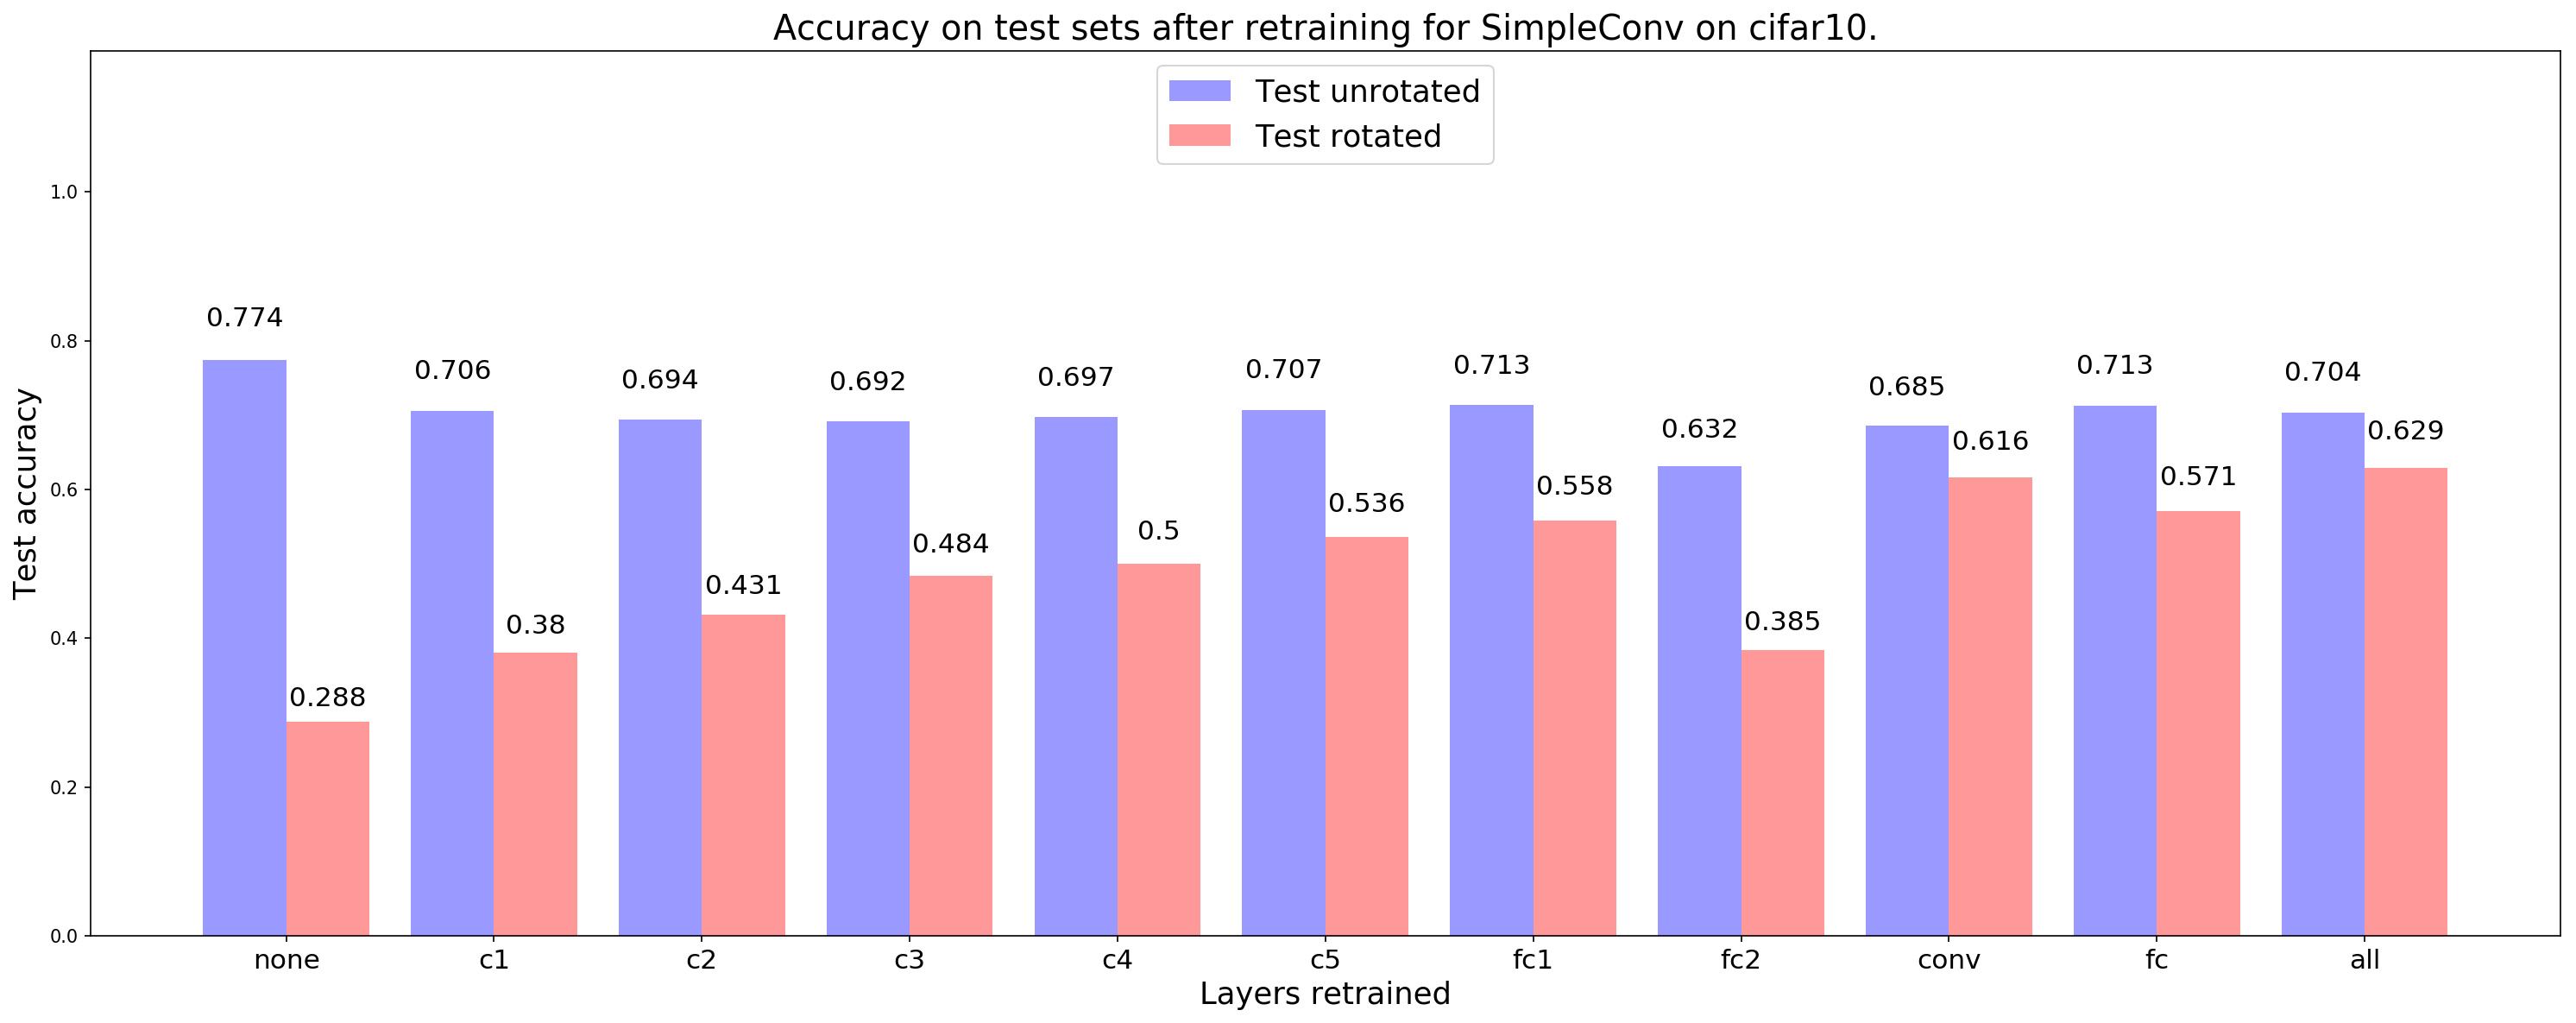

'plots/retraining_SimpleConv_cifar10.png'

In [51]:

pytorch_experiment.retraining_accuracy_barchart(model.name,dataset.name,unrotated_accuracies,rotated_accuracies,labels,savefig=True)

In [6]:
from datetime import datetime

output_file="results/retraining_simple_conv.txt"
general_message="%s\nResults on dataset %s with model %s\n" % (str(datetime.now()),dataset.name,model.name,)

pytorch_experiment.write_scores(scores,output_file,general_message)


2018-09-10 18:43:44.407149
Results on dataset mnist with model SimpleConv

None_rotated_test_dataset score: loss=3.863334, accuracy=0.419300

None_rotated_train_dataset score: loss=3.926329, accuracy=0.412317

None_test_dataset score: loss=0.043758, accuracy=0.985900

None_train_dataset score: loss=0.041138, accuracy=0.987500

retrained_c1_rotated_test_dataset score: loss=1.849418, accuracy=0.434500

retrained_c1_rotated_train_dataset score: loss=1.859314, accuracy=0.428283

retrained_c1_test_dataset score: loss=0.548009, accuracy=0.977200

retrained_c1_train_dataset score: loss=0.541860, accuracy=0.977917

retrained_c1_c2_c3_c4_c5_rotated_test_dataset score: loss=0.237550, accuracy=0.925300

retrained_c1_c2_c3_c4_c5_rotated_train_dataset score: loss=0.261971, accuracy=0.919800

retrained_c1_c2_c3_c4_c5_test_dataset score: loss=0.191369, accuracy=0.940100

retrained_c1_c2_c3_c4_c5_train_dataset score: loss=0.200448, accuracy=0.937650

retrained_c1_c2_c3_c4_c5_fc1_fc2_rotated_test_datas